# UM SIADS 695 Project: Predicting text difficulty
By Team 27: Thomson Choi (tschoi@umich.edu)

## Motivation
The objective of the project is to predict the classification of whether a sentence needs simplification in order to improve the readability of Wikipedia articles.

As described on the Kaggle page https://www.kaggle.com/c/umich-siads-695-predicting-text-difficulty, in order to make knowledge useable by learners of various age and education levels, it would be useful to identify articles or sentences which needs to be simplified so they can be consumed by more learners.  With a large labelled dataset provided, we hope to identify features in the training data from Wikipedia to accurately predict whether simplification is needed.

## Data Source

The project utilizes the Predicting text difficulty dataset provided at Kaggle: https://www.kaggle.com/c/umich-siads-695-predicting-text-difficulty

The dataset contains:

*   *WikiLarge_Train.csv* contains 417k entries of sentences from Wikipedia articles and also labelled for our target - whether the sentence needs simplification.  
*   *WikiLarge_Test.csv* contains 119k entries of sentences to be predicted that can be submitted to Kaggle for an accuracy score leaderboard.
*   *dale_chall.txt* contains 3000 words considered basic English.
*   *Concreteness_ratings_Brysbaert_et_al_BRM.txt* contains concreteness ratings for 40k English lemma words gathered via Amazon Mechanical Turk.
*   *AoA_51715_words.csv* contains "Age of Acquisition" (AoA) estimates for about 51k English words.

All dataset are in csv of text format containing strings and integer labels which can be imported easily into Python to work with.

# Part A - Supervised Learning
Motivation: The supervised part A will aim to achieve the classification goal with the training data with labels provided.

Data Source: We will utilize the Data Source described in 1.2.

## Methods and Evaluation

**Feature representation**: The provided dataset contains one sentence on each row.  First we need to engineer features as inputs to the classifier.  An obvious starting point is to utilize sklearn CountVectorizer to represent the text as vectors of count of words in a bag-of-words model.  We can also include total numbers of characters and words. Stemming of words will be tried as well.

**Methods**: To establish a baseline, I will first use a **Naive Bayes classifier** since it is speedy and can handle a large number of features efficiently (we have a large sparse matrix of words as input features).  Then I will experiment with various machine learning algorithms such as **Gradient Boosted Decision Trees** and **Multilayer Perceptron Neural Network**.  These algorithms take longer to train but I would expect them to achieve a higher accuracy.  

**Evaluation Plan**: To evaluate accuracy, I will use Cross-validation on the training data for better generalization of metrix. I will employ GridSearch for parameter tuning as well.  Another metric would be F1 to evaluate generalizability of model.

**Visualization**: We can potentially visualize the results by observing the feature importance ranking of words that appear the most in the class labeled needing simplification, indicating difficult words, and vice versa for the easy words.


In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
import os

In [150]:
# Code to connect to Google Drive if working on Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [151]:
# Code to connect to Google Drive if working on Colab
# import sys
# sys.path.append("/content/gdrive/MyDrive/3. UM MADS/2021 Summer/SIADS 694 695/kaggle")
# root_path = "/content/gdrive/MyDrive/3. UM MADS/2021 Summer/SIADS 694 695/kaggle/"

root_path = "./"

## Data Preparation

In [3]:
# Import Training data
df = pd.read_csv(root_path + 'WikiLarge_Train.csv')

### Stemming & Count Vectorizer
Stemming will help to consolidate words with different tenses or grammatical variations but with same stem and therefore level of difficulty.

We don't do lemmatization because that can alter the difficulty of words, as the word root will be altered. Someone who doesn't understand a word might understand its lemma.

Method references:
*   https://www.geeksforgeeks.org/snowball-stemmer-nlp/
*   https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn

Then we use Count Vectorizer to vectorize the counts of the stemmed words in each document.


In [4]:
from nltk.stem.snowball import EnglishStemmer
import re

stemmer = EnglishStemmer()

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
# r”(?u)\b\w\w+\b”

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

vectorizer_s = StemmedCountVectorizer(preprocessor=preprocess_text,
                                      analyzer = 'word', 
                                       stop_words='english', 
                                       max_features=50000, 
                                       lowercase=True, 
                                       max_df=0.95,
                                       min_df=10  # Eliminates a lot of words
                                     ) 


In [5]:
# Load pretrained model and result

if os.path.exists(root_path + 'res.pkl'):
    res = pickle.load(open(root_path + 'res.pkl', 'rb'))
else:
    res = vectorizer_s.fit_transform(df['original_text'])
    pickle.dump(res, open(root_path + 'res.pkl', 'wb'))

if os.path.exists(root_path + 'vec_s.pkl'):
    vec_s = pickle.load(open(root_path + 'vec_s.pkl', 'rb'))
else:
    res = vectorizer_s.fit_transform(df['original_text'])
    pickle.dump(vectorizer_s, open(root_path + 'vec_s.pkl', 'wb'))

### Explore Data sample

In [283]:
print('doc-term matrix shape:', res.shape)
print('doc-term matrix initial row:\n', res[0])

doc-term matrix shape: (416768, 23953)
doc-term matrix initial row:
   (0, 183)	1
  (0, 836)	1
  (0, 1438)	2
  (0, 4649)	1
  (0, 6486)	1
  (0, 7096)	1
  (0, 10902)	1
  (0, 11981)	2
  (0, 13061)	1
  (0, 14650)	1
  (0, 14792)	1
  (0, 16132)	1
  (0, 16359)	1
  (0, 23502)	1


In [7]:
feature_names = vec_s.get_feature_names()
vocab = vec_s.vocabulary_

print('# of features:', len(feature_names))
print('doc:', df.iloc[0, 0])
print('sample terms:')
rows, cols = res[0].nonzero()
for j in cols:
    print(feature_names[j], res[0][0,j])

# of features: 23953
doc: There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .
sample terms:
manuscript 1
evid 1
austen 2
continu 1
work 1
piec 1
late 2
period 1
niec 1
nephew 1
anna 1
jame 1
edward 1
addit 1


## Feature Engineering and External data


### Word Count
We count the number of words in the document

In [8]:
num_words = res.sum(axis=1)

### Character Count
We count the number of characters in the doc.

In [9]:
# character count
res_char_count = df['original_text'].map(len).to_numpy()
res_char_count = res_char_count.reshape(-1,1)

### External Data
We import the external data as described in 1.2 Data Source.

In [10]:
# Dale Chall 3000 word list: simple words
dc = pd.read_csv(root_path + 'dale_chall.txt', header=None)

# Concreteness Ratings
concr = pd.read_csv(root_path + 'Concreteness_ratings_Brysbaert_et_al_BRM.txt', sep='\t')
# Words are already Lemma
concr = concr[['Word', 'Conc.M', 'Percent_known']]

# Age of Acquisition
aoa = pd.read_csv(root_path + 'AoA_51715_words.csv', encoding = "ISO-8859-1")
aoa = aoa[['Word', 'AoA_Kup_lem']]

**Feature engineering from External Data**

For each feature word, we need to have a matrix to get:
* one hot for Dale Chall vector
* concreteness score vector
* AoA vector

New feature can be obtained by multiplying word feature sparse matrix with these vectors and to obtain new features that is a summary of the word features' characteristics based on these external data. For example, how many words are in Dale Chall list, what is the weighted Concreteness rating and the weighted Age of Acquisition by the words in the document.

##### Dale-Chall (One-Hot)

In [11]:
dc_vec = np.ndarray((len(feature_names),1))
stemmed_dc = dc[0].map(stemmer.stem)
for i in range(len(stemmed_dc)):
    stemmed_dc[i] = re.sub(r' ', '', stemmed_dc[i])

for i in range(len(feature_names)):
    if feature_names[i] in stemmed_dc.tolist():
        dc_vec[i] = 1
    else:
        dc_vec[i] = 0

print('There are', str(dc_vec[dc_vec==1].shape[0]), 'words that are in Dale-Chall list, out of', res.shape[1], 'words in the training data')

There are 2305 words that are in Dale-Chall list, out of 23953 words in the training data


##### Concreteness

In [12]:
concr_stemmed = concr['Word'].astype(str).map(stemmer.stem)
for i in range(len(concr_stemmed)):
    concr_stemmed[i] = re.sub(r' ', '', concr_stemmed[i])

concr['word_stemmed'] = concr_stemmed
concr = concr.set_index('word_stemmed').drop('Word', axis=1)

# There are dupe stems once stemmed
concr=concr.groupby(concr.index).agg(np.mean)
print('Mean concreteness rating of the words: ', concr['Conc.M'].mean())
print('Percent of people who knew the word: ', concr['Percent_known'].mean())

Mean concreteness rating of the words:  3.243044319902238
Percent of people who knew the word:  0.9632478617871354


We fill in missing data: when a word does not have a concreteness rating or percent of people who knew the word, we fill the mean of the data set as the value for that word feature.

In [284]:
concr_vec = np.ndarray((len(feature_names),2))

for i in range(len(feature_names)):
    try:
        concr_vec[i, 0] = concr.loc[feature_names[i], 'Conc.M']
    except:
        concr_vec[i, 0] = concr['Conc.M'].mean()
    try:
        concr_vec[i, 1] = concr.loc[feature_names[i], 'Percent_known']
    except:
        concr_vec[i, 1] = concr['Percent_known'].mean()
print('Check the means :', concr_vec.mean(axis=0))

Check the means : [3.26256425 0.96853254]


##### Age of Acquisition

In [15]:
aoa_stemmed = aoa['Word'].astype(str).map(stemmer.stem)
for i in range(len(aoa_stemmed)):
    aoa_stemmed[i] = re.sub(r' ', '', aoa_stemmed[i])

aoa['word_stemmed'] = aoa_stemmed
aoa = aoa.set_index('word_stemmed').drop('Word', axis=1)

# There are dupe stems once stemmed
aoa=aoa.groupby(aoa.index).agg(np.mean)
aoa_vec = np.ndarray((len(feature_names),1))

for i in range(len(feature_names)):
    try:
        aoa_vec[i, 0] = aoa.loc[feature_names[i], 'AoA_Kup_lem']
    except:
        aoa_vec[i, 0] = aoa['AoA_Kup_lem'].mean()

print('Mean age of acquisition:', aoa_vec.mean(axis=0))

Mean age of acquisition: [10.36053538]


### Combine Features into Features Matrix

In [285]:
import warnings
warnings.filterwarnings('ignore')

# add word count and char counts
from scipy.sparse import hstack
X = hstack((res, num_words, res_char_count, 
            np.nan_to_num(res @ dc_vec / num_words, nan=0),
            np.nan_to_num(res @ concr_vec / num_words, nan=0),
            np.nan_to_num(res @ aoa_vec / num_words, nan=0)))
X

<416768x23959 sparse matrix of type '<class 'numpy.float64'>'
	with 6243849 stored elements in COOrdinate format>

## Supervised Learning Methods

### Naive Bayes
We use Multinomial Naive Bayes model to set a base line of accuracy to be achieved by the Count Vectorizer input features.


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

y = df['label']
def MN_naive_bayes(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    nbclf = MultinomialNB().fit(X_train, y_train)
    print('train score:', round(nbclf.score(X_train, y_train),4))
    print('test score:', round(nbclf.score(X_test, y_test),4))
    return nbclf

In [18]:
# Bag of words with Word Count, Character Word, Dale-Chall list, Concreteness rating, AoA average
nb_res = MN_naive_bayes(res, y)

train score: 0.6512
test score: 0.6004


Let's check feature importance in the MultinomialNB model:

In [213]:
comb_features = feature_names + ['**Num Words**', '**Char Count**', '**DC Vec**', '**Concr Vec**', 
                                 '**Concr Pct Known**', '**AoA Vec**']
print('Words that contributes to predicting a need for simplification:',
      [comb_features[idx] for idx in np.argsort(nb_res.feature_log_prob_[1, :])[:10]])
print('Words that are low probability to predicting a need for simplification:',
      [comb_features[idx] for idx in np.argsort(nb_res.feature_log_prob_[1, :])[-10:]])
print('Lowest log_probab:', sorted(nb_res.feature_log_prob_[1, :])[0])
print('Highest log_probab:', sorted(nb_res.feature_log_prob_[1, :])[-1])
print('')
dict(zip(comb_features[-5:], nb_res.feature_log_prob_[1, -5:]))

Words that contributes to predicting a need for simplification: ['voivodship', 'horrorcor', 'kms', 'esteghl', 'seyß', 'dazur', 'werkelijk', 'divoir', 'didnt', 'politican']
Words that are low probability to predicting a need for simplification: ['depart', 'unit', 'known', 'franc', 'citi', 'born', 'use', 'state', 'lrb', 'rrb']
Lowest log_probab: -14.426007926973522
Highest log_probab: -3.63953826660698



{'**Char Count**': -11.430275653419532,
 '**DC Vec**': -10.64181829305526,
 '**Concr Vec**': -12.816570014539423,
 '**Concr Pct Known**': -12.123422833979475,
 '**AoA Vec**': -11.717957725871312}

The engineered features have relatively low log_probab for predicting a text to be difficult. 

The scores with NB is not high, we're going to attempt to enrich features first before using other machine learning algorithms.
Let's try Unsupervised Learning methods before returning to Supervised Learning methods.  We will return to evaluating our Supervised Methods after applying Unsupervised Learning methods to our input features set, as well as conducting failure analysis.

# Part B - Unsupervised Learning

## Motivation
The motivation of applying unsupervised learning methods is to simplify the close to 24k word-term features from the Count Vectorizer, in order to make our model selection and training more time-efficient.  We will use dimension reduction methods such as K-means clustering, Truncated SVD and Non-negative Matrix Factorization and utilize the result reduced feature set back in Supervised Learning models to see which model performs the best before returning to use the full Count Vectorizer feature set. 

The Unsupervised Learning methods will be applied on the Count Vectorizer features only and will not apply to word count, character count, or the external data vectors because those are already summary features that do not need dimension reduction.

With less number of features we expect the model selection to take less time, although sacrificing some accuracy due to dimension reduction with a lost in resolution of the original data.

## K Means Clustering

In [286]:
from sklearn.cluster import KMeans

force_kmeans = False
if os.path.exists(root_path + 'kmeans.pkl') and force_kmeans==False:
    kmeans = pickle.load(open(root_path + 'kmeans.pkl', 'rb'))
    res_k_means = kmeans.transform(res)
else:    
    kmeans = KMeans(n_clusters=10, random_state=0)
    kmeans.fit(res)
    res_k_means = kmeans.transform(res)
    pickle.dump(kmeans, open(root_path + 'kmeans.pkl', 'wb'))

K Means clustering takes 10 mins for 5 clusters. 13 mins for 10 clusters

In [21]:
MN_naive_bayes(res_k_means, y)

train score: 0.5965
test score: 0.5953


MultinomialNB()

We attempt to evaluation how well the clusters are formed by K-means clustering by Silhouette Coefficient and Calinski Harabasz score.

In [287]:
from sklearn import metrics
print('Silhouette Coeff: %0.3f' % metrics.silhouette_score(res, kmeans.labels_, sample_size=1000))

Silhouette Coeff: -0.012


We find that Calinski Harabasz score requires the input feature matrix to be dense and not sparse.  The session crashed because out of RAM when converting word features sparse matrix to dense.  We failed to get a Calinski Harabasz score due to the size of our input data.

In [289]:
# This would crash:
# metrics.calinski_harabasz_score(res.toarray(), kmeans.labels_)

Conclusion: K-means clustering doesn't look to give us well defined clusters based on the Silhouette Coefficient.

## Truncated SVD

In [311]:
from sklearn.decomposition import TruncatedSVD

force_svd = False
if os.path.exists(root_path + 'svd.pkl') and force_svd==False:
    svd = pickle.load(open(root_path + 'svd.pkl', 'rb') )
    Xsvd = svd.fit_transform(res)
else:  
    svd = TruncatedSVD(100)
    Xsvd = svd.fit_transform(res)
    pickle.dump(svd, open(root_path + 'svd.pkl', 'wb'))

print(Xsvd.shape)
print(svd.explained_variance_ratio_.sum())

(416768, 100)
0.25142898599826474


The explained variance ratio is low with SVD of 100 components, which is not satisfactory.  

We can see some of the words in the top 5 components in the decomposition.

In [296]:
for j in range(5):
    print([feature_names[i] for i in np.argsort(svd.components_[j, :])[-5:]])

['known', 'footbal', 'born', 'lrb', 'rrb']
['pas', 'commune', 'region', 'depart', 'franc']
['new', 'counti', 'citi', 'unit', 'state']
['team', 'player', 'play', 'born', 'footbal']
['world', 'time', 'new', 'year', 'use']


Since SVD produces negative values, it is not usable using Multinomial Naive Bayes.  The following cell fails.

In [301]:
# This would fail
# MN_naive_bayes(Xsvd, y)

## Non-negative Matrix Factorization

We would not run into the same problem with NMF as we did with SVD since the decomposition would result in non-negative matrix so we can use it with MultinomialNB.

In [298]:
from sklearn.decomposition import NMF

force_nmf = False
if os.path.exists(root_path + 'nmf.pkl') and force_nmf==False:
    nmf = pickle.load(open(root_path + 'nmf.pkl', 'rb'))
    Xnmf = nmf.transform(res)
else:  
    nmf = NMF(n_components=100, random_state=0, init='nndsvd').fit(res)
    Xnmf = nmf.transform(res)
    pickle.dump(nmf, open(root_path + 'nmf.pkl', 'wb'))
    
Xnmf.shape

(416768, 100)

In [29]:
MN_naive_bayes(Xnmf, y)

train score: 0.5643
test score: 0.5637


MultinomialNB()

## T-SNE Visualization on output of NMF

Preview: sklearn T-SNE takes a long time: it took 5 hours on the 100 dimension X with NMF.
(Another implementation is suggested here: https://medium.com/rapids-ai/tsne-with-gpus-hours-to-seconds-9d9c17c941db
But only supports Linux machines.)

In [110]:
# from adspy_shared_utilities import plot_labelled_scatter
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 0)
X_tsne = tsne.fit_transform(Xnmf)
# pickle.dump(X_tsne, open('./pickle/' + 'X_tsne.pkl', 'wb'))
# pickle.dump(tsne, open('./pickle/' + 'tsne.pkl', 'wb'))

In [114]:
X_tsne.shape

(416768, 2)

In [120]:
tsne.n_iter_

999

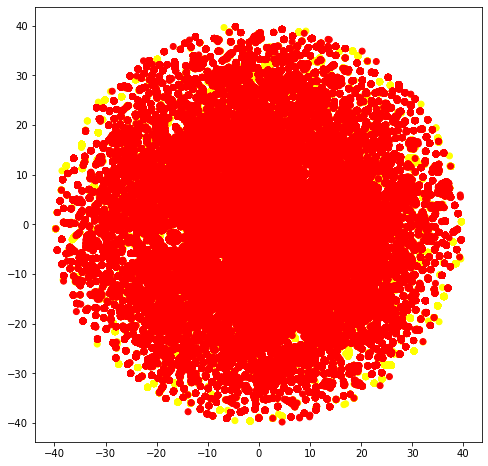

In [302]:
import matplotlib.pyplot as plt

X_tsne = pickle.load(open('./pickle/' + 'tsne.pkl', 'rb')).embedding_
plt.figure(figsize=(8,8))
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=df['label'], cmap='autumn')


The result is not satisfactory, there are too many clusters and they do not help us determine whether the cluster is more simple or complex that needs simplification, as they overlap with each other.

### Smaller data set

Let's try a smaller data set with a less n-components NMF and with different hyperparameters in T-SNE.

We will apply TSNE on matrix after NMF with 20 components only. This time we will adjust perplexity to a small value at 5, and learning rate 10, with n_iter and n_iter_without_progress to shorter training time.  We will also only use 30% of the data.

In [306]:
if os.path.exists('./pickle/' + 'nmf20.pkl'):
    nmf20 = pickle.load(open('./pickle/' +  'nmf20.pkl', 'rb'))
else:
    nmf20 = NMF(n_components=20, random_state=0, init='nndsvd').fit(res)
    pickle.dump(nmf20, open('./pickle/' + 'nmf20.pkl', 'wb'))
    
if os.path.exists('./pickle/' + 'Xnmf20.pkl'):
    Xnmf20 = pickle.load(open('./pickle/' +  'Xnmf20.pkl', 'rb'))
else:
    Xnmf20 = nmf20.transform(res)
    pickle.dump(Xnmf20, open('./pickle/' + 'Xnmf20.pkl', 'wb'))

In [308]:
X_train, X_test, y_train, y_test = train_test_split(Xnmf20, df['label'], random_state=0, train_size=0.3)

if os.path.exists('./pickle/' + 'tsne_small.pkl'):
    tsne_small = pickle.load(open('./pickle/' + 'tsne_small.pkl', 'rb'))
else:
    tsne_small = TSNE(perplexity=5, learning_rate=10, n_iter=500, n_iter_without_progress=100,
                  random_state = 0, n_jobs=-1, verbose=True)
    pickle.dump(tsne_small, open('./pickle/' + 'tsne_small.pkl', 'wb'))
    
if os.path.exists('./pickle/' + 'X_tsne_small.pkl'):
    X_tsne_small = pickle.load(open('./pickle/' + 'X_tsne_small.pkl', 'rb'))
else:
    X_tsne_small = tsne_small.fit_transform(X_train)
    pickle.dump(X_tsne_small, open('./pickle/' + 'X_tsne_small.pkl', 'wb'))


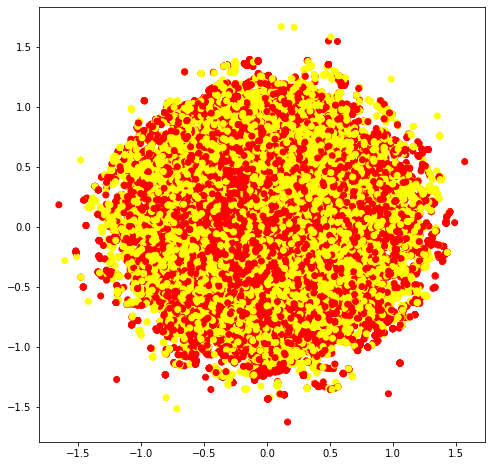

In [309]:
plt.figure(figsize=(8,8))
plt.scatter(x=X_tsne_small[:,0], y=X_tsne_small[:,1], c=y_train, cmap='autumn')

Similarly it is not apparent the T-sne visualization help us on any insights into clusters in the dataset of features after NMF.

## T-SNE Visualization on output of K-means clustering

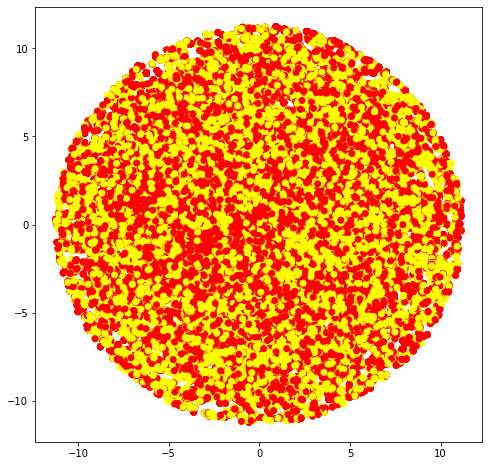

In [313]:
X_train, X_test, y_train, y_test = train_test_split(res_k_means, df['label'], random_state=0, train_size=0.3)

tsne_kmeans_small = TSNE(perplexity=5, learning_rate=10, n_iter=1000, n_iter_without_progress=100,
                  random_state = 0, n_jobs=-1, verbose=False)
X_tsne_kmeans_small = tsne_kmeans_small.fit_transform(X_train)

plt.figure(figsize=(8,8))
plt.scatter(x=X_tsne_kmeans_small[:,0], y=X_tsne_kmeans_small[:,1], c=y_train, cmap='autumn')

Similar non-conclusive results in T-SNE visualization on output of K-means clustering

## Part B Unsupervised Evaluation

Among the three dimension reduction unsupervised methods, judging by the result of MultinomialNB, we find that K-means features produced the closest test accuracy 0.5953 to the original data with 0.6004, followed by NMF features 0.5637 which was significantly worse. 

In order to visualize the findings, we attempted T-SNE visualization.  However we're not able to see clear clusters from K-means or NMF transformed features, which means after the unsupervised methods to reduce dimensions, the groups of words in each feature do not cluster together that can tell easily which text needs simplification, and each feature is relatively equidistant to each other.

# Return to Part A Supervised Learning after Features Engineering with Unsupervised Learning

## Gradient Boosted Decision Tree

In [34]:
word_vectors = [res, res_k_means, Xsvd, Xnmf]
word_vectors_names = ['Word Vector', 'Word K-Means 100 Clusters', 'Word SVD 100 components', 'Word NMF 100 components']
word_vectors_file = ['wordvec', 'kmeans', 'svd', 'nmf']
force_gbdt = False

from sklearn.ensemble import GradientBoostingClassifier
import scipy
from scipy.sparse import hstack # hstack only for sparse matrix
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# getX function helps us combine the word features with or without dimension reduction to the engineered features
def getX(word_vec):
    if type(word_vec) == scipy.sparse.csr.csr_matrix:
        X = hstack((word_vec, num_words, res_char_count, 
                np.nan_to_num(res @ dc_vec / num_words, nan=0),
                np.nan_to_num(res @ concr_vec / num_words, nan=0),
                np.nan_to_num(res @ aoa_vec / num_words, nan=0)))
    else: 
        X = np.concatenate((word_vec, num_words, res_char_count, 
                np.nan_to_num(res @ dc_vec / num_words, nan=0),
                np.nan_to_num(res @ concr_vec / num_words, nan=0),
                np.nan_to_num(res @ aoa_vec / num_words, nan=0)), axis=1)
    return X

def gradboost(X, y, l_rate=0.3, n_est=200, max_d=5, train_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    gbdt = GradientBoostingClassifier(learning_rate=l_rate, n_estimators=n_est, max_depth=max_d)
    gbdt.fit(X_train, y_train)
    
    print('train score:', round(gbdt.score(X_train, y_train),4))
    print('test score:', round(gbdt.score(X_test, y_test),4))
    print('f1_score:', f1_score(y_test, gbdt.predict(X_test)))
    
    return gbdt

In [162]:
for i in range(len(word_vectors)):
    print(word_vectors_names[i])
    path_gbdt = root_path + 'pickle/gbdt_' + word_vectors_file[i] + '.pkl'
    if os.path.exists(path_gbdt) and force_gbdt==False:
        gbdt = pickle.load(open(path_gbdt, 'rb'))
        X = getX(word_vectors[i])
        y = df['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.3)
        print('train score:', round(gbdt.score(X_train, y_train),4))
        print('test score:', round(gbdt.score(X_test, y_test),4))
        print('f1_score:', f1_score(y_test, gbdt.predict(X_test)))
        print('--------------')
    else:
        gbdt = gradboost(getX(word_vectors[i]), y=df['label'])
        pickle.dump(gbdt, open(path_gbdt, 'wb'))

Word Vector
train score: 0.7236
test score: 0.6817
f1_score: 0.6864259398712056
--------------
Word K-Means 100 Clusters
train score: 0.7116
test score: 0.6518
f1_score: 0.6670010161602256
--------------
Word SVD 100 components
train score: 0.6624
test score: 0.6421
f1_score: 0.6500961789800337
--------------
Word NMF 100 components
train score: 0.7512
test score: 0.6718
f1_score: 0.6736466129537988
--------------


We find that the features generated by by original word count vector is the best but has 23k features, while non-negative matrix factorization with 100 features is the best out of all dimension reduction by K-means or SVD.  


We have tried to train the Gradient Boosting model with the original word count vector with 23k features and would take about an hour to finish while the NMF features with ~100 features would only take 1/10 of the time.

For performance and training efficiency, we will continue our study with the features generated by NMF in order to save computing time.


### Grid Search

In [316]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), df['label'], random_state=0)
params = {'n_estimators': [100,200,300]
          }
gbdt = GradientBoostingClassifier(learning_rate=0.3, max_depth = 5)
clf = GridSearchCV(gbdt, params, scoring='accuracy', cv=2, n_jobs=-1)
clf.fit(X_train, y_train)
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,576.422243,0.158577,1.051687,0.012468,100,{'n_estimators': 100},0.673398,0.674671,0.674034,0.000637,1
1,1030.434389,0.395941,1.567308,0.016457,200,{'n_estimators': 200},0.673097,0.673871,0.673484,0.000387,2
2,1403.735894,0.460767,1.642108,0.035405,300,{'n_estimators': 300},0.672176,0.674038,0.673107,0.000931,3


In [317]:
print('f1_score:', f1_score(y_test, clf.predict(X_test)))

f1_score: 0.6838851178884079


First we tried to search for n_estimators variable by Grid Search. The best score was with n_estimators = 100, but this might be due to cv=2 parameter.  We observe that n_estimators 200 estimators takes ~50% more time than 100 estimators.  We also ran the training separately, for the input features we find that 200 estimators improved accuracy by 0.0030 vs 100 estimators, so there is not a signficant pickup to trade off for the time efficiency. We will continue our exploration with n_estimators = 100.

Then we do Grid Search on learning rate. We find 0.25 is the best learning rate.

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), df['label'], random_state=0)
params = {'learning_rate': [0.15,0.20,0.25]
          }
gbdt = GradientBoostingClassifier(n_estimators=100, max_depth = 5)
clf = GridSearchCV(gbdt, params, scoring='accuracy', cv=2, n_jobs=-1)
clf.fit(X_train, y_train)
# print('train score:', round(gbdt.score(X_train, y_train),4))
# print('test score:', round(gbdt.score(X_test, y_test),4))

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(max_depth=5), n_jobs=-1,
             param_grid={'learning_rate': [0.15, 0.2, 0.25]},
             scoring='accuracy')

In [48]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,537.568196,0.274749,1.209028,0.017571,0.15,{'learning_rate': 0.15},0.673839,0.674230,0.674034,0.000195,3
1,536.502786,0.225565,1.186750,0.046863,0.2,{'learning_rate': 0.2},0.674268,0.674626,0.674447,0.000179,2
2,535.807676,0.512789,0.892412,0.224790,0.25,{'learning_rate': 0.25},0.675221,0.674869,0.675045,0.000176,1


In [50]:
# pickle.dump(clf, open('./pickle/gbdt_gridsearchcv_Lr.pkl', 'wb'))

### Train best GBDT model

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0)
gbdt = GradientBoostingClassifier(learning_rate=0.25, n_estimators=100, max_depth=5)
gbdt.fit(X_train, y_train)
print('train score:', round(gbdt.score(X_train, y_train),4))
print('test score:', round(gbdt.score(X_test, y_test),4))
# pickle.dump(gbdt, open('./pickle/best_gbdt.pkl', 'wb'))

train score: 0.6931
test score: 0.679


In [322]:
gbdt=pickle.load(open('./pickle/best_gbdt.pkl', 'rb'))
X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0)
print('f1_score:', f1_score(y_test, gbdt.predict(X_test)))

f1_score: 0.6854617265375212


In [56]:
X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0)
gbdt = GradientBoostingClassifier(learning_rate=0.25, n_estimators=200, max_depth=5)
gbdt.fit(X_train, y_train)
print('train score:', round(gbdt.score(X_train, y_train),4))
print('test score:', round(gbdt.score(X_test, y_test),4))

train score: 0.709
test score: 0.682


In [57]:
# pickle.dump(gbdt, open('./pickle/best_gbdt_n_est200.pkl', 'wb'))

In [157]:
from sklearn.metrics import f1_score

gbdt=pickle.load(open('./pickle/best_gbdt_n_est200.pkl', 'rb'))
X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0)
print('f1_score:', f1_score(y_test, gbdt.predict(X_test)))

f1_score: 0.6863034709992615


## Multilayer Perceptron

1. Multilayer Perceptron with Relu activation, 2 layers (20,20)

In [70]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.4)

print('X_train shape:', X_train.shape)

nnclf = MLPClassifier(hidden_layer_sizes = (20,20,), solver='adam', activation='relu',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf.fit(X_train, y_train)
print('n iterations:', nnclf.n_iter_)
print('train score:', round(nnclf.score(X_train, y_train),4))
print('test score:', round(nnclf.score(X_test, y_test),4))
# pickle.dump(nnclf, open('mlp_relu.pkl', 'wb'))

X_train shape: (166707, 106)
n iterations: 34
train score: 0.6463
test score: 0.6446


2. Multilayer Perceptron with Logistic activation, 2 layers (20,20)

In [72]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.4)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (20,20,), solver='adam', activation='logistic',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4))
# pickle.dump(nnclf_logis, open('mlp_logistic.pkl', 'wb'))

X_train shape: (166707, 106)
n iterations: 62
train score: 0.649
test score: 0.6465


Multilayer Perceptron with Logistic activation, 2 layers (20,20) achieve better results with no significant difference in training times.  We will take it as the base case to compare different variations in hyperparameters.

In [163]:
nnclf_logis = pickle.load(open('mlp_logistic.pkl', 'rb'))
base_train = nnclf_logis.score(X_train, y_train)
base_test = nnclf_logis.score(X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.4)
base_f1 = f1_score(y_test, nnclf_logis.predict(X_test))

### More layers 3 layers

In [166]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.4)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (20,20,20,), solver='adam', activation='logistic',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4), 
      'diff:', round(nnclf_logis.score(X_train, y_train) - base_train,4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4),
      'diff:', round(nnclf_logis.score(X_test, y_test) - base_test,4))
print('f1 score:', round(f1_score(y_test, nnclf_logis.predict(X_test)),4),
      'diff:', round(f1_score(y_test, nnclf_logis.predict(X_test)) - base_f1,4))

X_train shape: (166707, 106)
n iterations: 40
train score: 0.6479 diff: -0.0007
test score: 0.6458 diff: -0.0013
f1 score: 0.656 diff: 0.0029


More layers actually made accuracy go down, but higher F1 score.  Let's try more neurons in each layer with 2 layers.

### More Neurons 2 layers

In [167]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.4)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (50,50,), solver='adam', activation='logistic',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4), 
      'diff:', round(nnclf_logis.score(X_train, y_train) - base_train,4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4),
      'diff:', round(nnclf_logis.score(X_test, y_test) - base_test,4))
print('f1 score:', round(f1_score(y_test, nnclf_logis.predict(X_test)),4),
      'diff:', round(f1_score(y_test, nnclf_logis.predict(X_test)) - base_f1,4))

X_train shape: (166707, 106)
n iterations: 60
train score: 0.6491 diff: 0.0006
test score: 0.6454 diff: -0.0017
f1 score: 0.6419 diff: -0.0111


Both test accuracy and F1 score were lower with more neurons vs base case.

### More Data: Train size 70%

In [168]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.7)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (20,20,), solver='adam', activation='logistic',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4), 
      'diff:', round(nnclf_logis.score(X_train, y_train) - base_train,4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4),
      'diff:', round(nnclf_logis.score(X_test, y_test) - base_test,4))
print('f1 score:', round(f1_score(y_test, nnclf_logis.predict(X_test)),4),
      'diff:', round(f1_score(y_test, nnclf_logis.predict(X_test)) - base_f1,4))

X_train shape: (291737, 106)
n iterations: 40
train score: 0.649 diff: 0.0005
test score: 0.6484 diff: 0.0013
f1 score: 0.6644 diff: 0.0113


More data was very effective in achieving a higher test accuracy and F1 score.  Let's try again more neurons and more layers.

In [169]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.7)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (50,50,50,), solver='adam', activation='logistic',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4), 
      'diff:', round(nnclf_logis.score(X_train, y_train) - base_train,4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4),
      'diff:', round(nnclf_logis.score(X_test, y_test) - base_test,4))
print('f1 score:', round(f1_score(y_test, nnclf_logis.predict(X_test)),4),
      'diff:', round(f1_score(y_test, nnclf_logis.predict(X_test)) - base_f1,4))

X_train shape: (291737, 106)
n iterations: 68
train score: 0.6537 diff: 0.0052
test score: 0.6527 diff: 0.0056
f1 score: 0.6596 diff: 0.0065


With more data, increasing number of neurons and more layers improves accuracy.

In [170]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.7)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (50,50,50,50,), solver='adam', activation='logistic',
                      max_iter=100, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4), 
      'diff:', round(nnclf_logis.score(X_train, y_train) - base_train,4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4),
      'diff:', round(nnclf_logis.score(X_test, y_test) - base_test,4))
print('f1 score:', round(f1_score(y_test, nnclf_logis.predict(X_test)),4),
      'diff:', round(f1_score(y_test, nnclf_logis.predict(X_test)) - base_f1,4))

X_train shape: (291737, 106)
n iterations: 34
train score: 0.6489 diff: 0.0004
test score: 0.6483 diff: 0.0012
f1 score: 0.668 diff: 0.0149


With even more layers, the test accuracy dropped but F1 score increased.

### Final MLP Model

In [172]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(getX(Xnmf), y, random_state=0, train_size=0.7)

print('X_train shape:', X_train.shape)

nnclf_logis = MLPClassifier(hidden_layer_sizes = (100,75,50,), solver='adam', activation='logistic',
                      max_iter=200, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0)

nnclf_logis.fit(X_train, y_train)
print('n iterations:', nnclf_logis.n_iter_)
print('train score:', round(nnclf_logis.score(X_train, y_train),4), 
      'diff:', round(nnclf_logis.score(X_train, y_train) - base_train,4))
print('test score:', round(nnclf_logis.score(X_test, y_test),4),
      'diff:', round(nnclf_logis.score(X_test, y_test) - base_test,4))
print('f1 score:', round(f1_score(y_test, nnclf_logis.predict(X_test)),4),
      'diff:', round(f1_score(y_test, nnclf_logis.predict(X_test)) - base_f1,4))

X_train shape: (291737, 106)
n iterations: 83
train score: 0.6563 diff: 0.0078
test score: 0.6557 diff: 0.0086
f1 score: 0.6754 diff: 0.0223


### MLP conlusion

With various iterations of MLP, the most significant improvement in test accuracy was due to increase of training data, and once training data was increased there is positive effects of having a deeper 3-layer network with an increased number of neurons.  When training data was small, accuracy did not increase with an additional layer or more neurons in the layers.
The highest F1 score for MLP was achieved by a 3-layer network with (100,75,50) neurons from experiment.

However, the MLP model was still inferior to Gradient Boosted Decision Tree with NMF input features.  Therefore our selection would be Gradient Boosted Decision Tree.

We will train the Gradient Boosted Decision Tree with the full training data with Word Count vector without dimension reduction or train/test split, in order to produce the final model for submission to kaggle.

# Model Selection

## Final Gradient Boosted Decision Tree

In [84]:
gbdt_best = GradientBoostingClassifier(learning_rate=0.25, n_estimators=200, max_depth=5, random_state=0, 
                                       verbose=1, n_iter_no_change=20, tol=0.0001)
X = getX(res)
y = df['label']
print('X shape:', X.shape)
gbdt_best.fit(X, y)
pickle.dump(gbdt_best, open('./pickle/gbdt_best.pkl', 'wb'))

X shape: (416768, 23959)
      Iter       Train Loss   Remaining Time 
         1           1.3333            7.19m
         2           1.3000            7.10m
         3           1.2786            7.01m
         4           1.2608            6.92m
         5           1.2493            6.90m
         6           1.2421            6.80m
         7           1.2368            6.76m
         8           1.2309            6.70m
         9           1.2271            6.65m
        10           1.2244            6.61m
        20           1.2039            6.17m
        30           1.1930            5.95m
        40           1.1845            5.65m
        50           1.1775            5.24m
        60           1.1711            4.86m
        70           1.1655            4.49m
        80           1.1605            4.13m
        90           1.1568            3.78m
       100           1.1524            3.43m
       200           1.1225            0.00s


In [87]:
print('train score:', round(gbdt_best.score(X, y),4))

train score: 0.7013


### Feature Importance

In [263]:
[comb_features[i] for i in np.argsort(-gbdt_best.feature_importances_)[:10]]

['**Char Count**',
 'commune',
 '**Num Words**',
 'ndash',
 '**AoA Vec**',
 '**DC Vec**',
 'depart',
 '**Concr Vec**',
 '**Concr Pct Known**',
 'counti']

The features with ** are the engineered features with character and word counts and DC, AoA, Concreteness external datasets.  They turn out to be in the top 10 importance features in the Gradient Boosted Decision Tree model, which is expected because intuition is that they indicate text difficulty and is a vector that takes into account the level of difficulty from the document words.

Let's look at the relative importance of the engineered features, and then also a word cloud of the top 100 words excluding these special features.

Text(0.5, 1.0, 'Engineered Feature Importance')

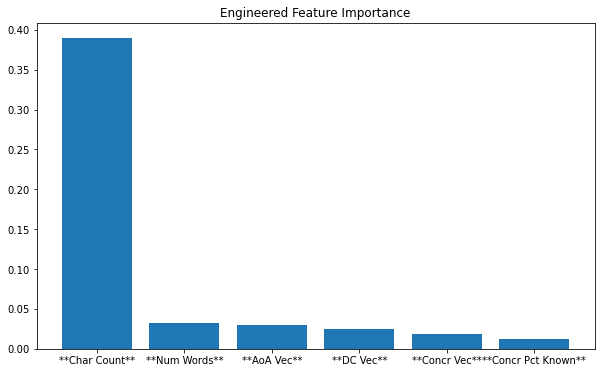

In [264]:
plt.figure(figsize=(10,6))
plt.bar(x=[comb_features[-6:][i] for i in np.argsort(-gbdt_best.feature_importances_[-6:])],
        height=sorted(gbdt_best.feature_importances_[-6:], reverse=True))
plt.title('Engineered Feature Importance')

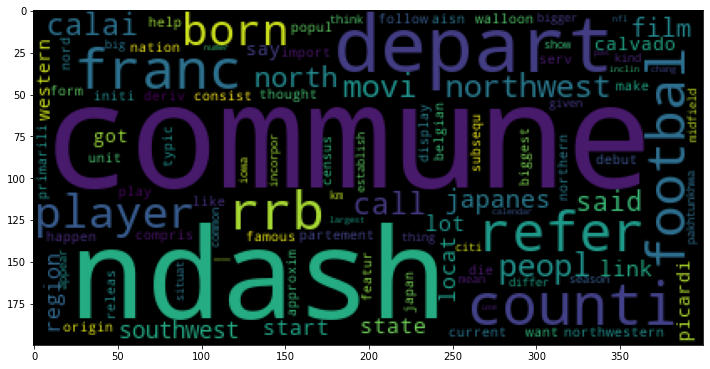

In [235]:
from wordcloud import WordCloud

wc=WordCloud()
wc.fit_words(dict(zip([comb_features[i] for i in np.argsort(-gbdt_best.feature_importances_[:-6])[:100]],
 sorted(gbdt_best.feature_importances_[:-6], reverse=True)[:100])))
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.show()

## MLP selected

In [175]:
nnclf_logis_best = MLPClassifier(hidden_layer_sizes = (100,75,50,), solver='adam', activation='logistic',
                      max_iter=200, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0, verbose=True)
X = getX(res)
y = df['label']
print('X shape:', X.shape)

nnclf_logis_best.fit(X, y)
pickle.dump(nnclf_logis_best, open('./pickle/nnclf_logis_best.pkl', 'wb'))

X shape: (416768, 23959)
Iteration 1, loss = 0.60892893
Validation score: 0.685438
Iteration 2, loss = 0.57353776
Validation score: 0.687262
Iteration 3, loss = 0.55661527
Validation score: 0.689949
Iteration 4, loss = 0.54684635
Validation score: 0.683518
Iteration 5, loss = 0.53934222
Validation score: 0.685342
Iteration 6, loss = 0.53379714
Validation score: 0.686326
Iteration 7, loss = 0.52667018
Validation score: 0.681695
Iteration 8, loss = 0.52037744
Validation score: 0.687573
Iteration 9, loss = 0.51337301
Validation score: 0.682247
Iteration 10, loss = 0.50547704
Validation score: 0.685174
Iteration 11, loss = 0.49779457
Validation score: 0.679392
Iteration 12, loss = 0.48972481
Validation score: 0.681503
Iteration 13, loss = 0.48210240
Validation score: 0.680351
Iteration 14, loss = 0.47254649
Validation score: 0.672625
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


# Submission of Prediction to Kaggle

## Submit with Gradient Boosted Decision Tree

In [88]:
test_csv = pd.read_csv(root_path + 'WikiLarge_Test.csv')

In [98]:
def combine_data(df):
    
    vec_s = pickle.load(open(root_path + 'vec_s.pkl', 'rb'))
    res_X_sub = vec_s.transform(df['original_text'])

    num_words = res_X_sub.sum(axis=1)
    res_X_char_count = df['original_text'].map(len).to_numpy().reshape(-1,1) 

    feature_names = vec_s.get_feature_names()

    # Dale Chall
    dc_vec = np.ndarray((len(feature_names),1))
    stemmed_dc = dc[0].map(stemmer.stem)
    for i in range(len(stemmed_dc)):
        stemmed_dc[i] = re.sub(r' ', '', stemmed_dc[i])

    for i in range(len(feature_names)):
        if feature_names[i] in stemmed_dc.tolist():
            dc_vec[i] = 1
        else:
            dc_vec[i] = 0

    # Concreteness
    concr_vec = np.ndarray((len(feature_names),2))

    for i in range(len(feature_names)):
        try:
            concr_vec[i, 0] = concr.loc[feature_names[i], 'Conc.M']
        except:
            concr_vec[i, 0] = concr['Conc.M'].mean()
        try:
            concr_vec[i, 1] = concr.loc[feature_names[i], 'Percent_known']
        except:
            concr_vec[i, 1] = concr['Percent_known'].mean()

    # AoA
    aoa_vec = np.ndarray((len(feature_names),1))

    for i in range(len(feature_names)):
        try:
            aoa_vec[i, 0] = aoa.loc[feature_names[i], 'AoA_Kup_lem']
        except:
            aoa_vec[i, 0] = aoa['AoA_Kup_lem'].mean()

#     # Xpca
#     clf = TruncatedSVD(100)
#     Xpca = clf.fit_transform(res_X_sub)

    X = hstack((res_X_sub, num_words, res_X_char_count, 
            np.nan_to_num(res_X_sub @ dc_vec / num_words, nan=0),
            np.nan_to_num(res_X_sub @ concr_vec / num_words, nan=0),
            np.nan_to_num(res_X_sub @ aoa_vec / num_words, nan=0)))

    return X

In [99]:
X = combine_data(test_csv)

In [100]:
print(X.shape)

(119092, 23959)


In [101]:
test_csv

,id,original_text,label
0,0,-2011,NaN
1,1,-2011,NaN
2,2,-2000,NaN
3,3,-1997,NaN
4,4,1.636,NaN
...,...,...,...
119087,119087,#NAME?,NaN
119088,119088,#NAME?,NaN
119089,119089,#NAME?,NaN
119090,119090,#NAME?,NaN


In [104]:
test_csv.loc[:,'label'] = gbdt_best.predict(X)

In [108]:
test_csv['label'].value_counts()

1    61740
0    57352
Name: label, dtype: int64

In [109]:
test_csv[['id','label']].to_csv('submission.csv', index=False)

Score:
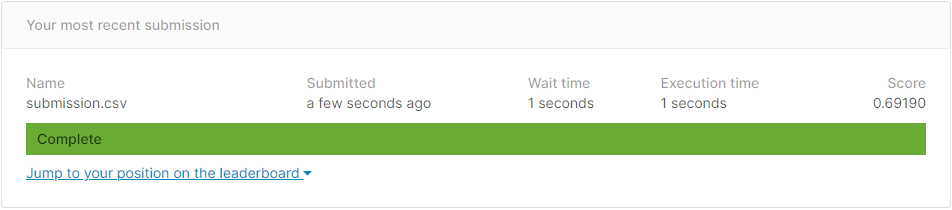

## Submit with MLP selected

In [176]:
X = combine_data(test_csv)

In [177]:
test_csv.loc[:,'label'] = nnclf_logis_best.predict(X)
test_csv['label'].value_counts()

In [179]:
test_csv[['id','label']].to_csv('submission_MLP.csv', index=False)

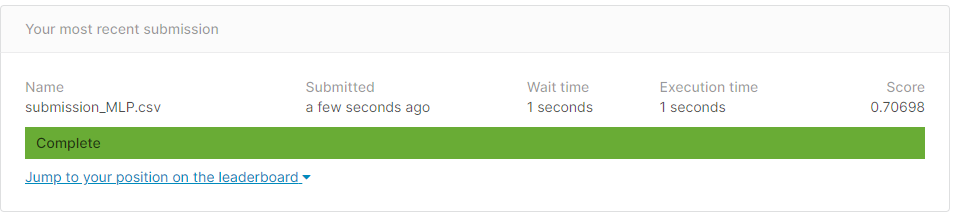


## More MLP

On the Kaggle leadership we see higher accuracy achieved by some teams.  We will try one more MLP with deeper and bigger layers (100,100,100,100,) and trained on the whole training data with word counts combined to length vector features without early stopping.  This is expected to take a long time.

In [180]:
nnclf_logis_more = MLPClassifier(hidden_layer_sizes = (100,100,100,100,), solver='adam', activation='logistic',
#                       max_iter=200, early_stopping=True, n_iter_no_change=10, tol=0.0001,
                      random_state = 0, verbose=True)
X = getX(res)
y = df['label']
print('X shape:', X.shape)

nnclf_logis_more.fit(X, y)
# pickle.dump(nnclf_logis_more, open('./pickle/nnclf_logis_more.pkl', 'wb'))

X shape: (416768, 23959)
Iteration 1, loss = 0.60716403
Iteration 2, loss = 0.57248261
Iteration 3, loss = 0.55629208
Iteration 4, loss = 0.54778729
Iteration 5, loss = 0.54086124
Iteration 6, loss = 0.53381557
Iteration 7, loss = 0.52716839
Iteration 8, loss = 0.51947503
Iteration 9, loss = 0.51192559
Iteration 10, loss = 0.50377885
Iteration 11, loss = 0.49530863
Iteration 12, loss = 0.48586223
Iteration 13, loss = 0.47660833
Iteration 14, loss = 0.46792015
Iteration 15, loss = 0.45811594
Iteration 16, loss = 0.44997755
Iteration 17, loss = 0.44065084
Iteration 18, loss = 0.43160185
Iteration 19, loss = 0.42175270
Iteration 20, loss = 0.41273571
Iteration 21, loss = 0.40579887
Iteration 22, loss = 0.39576675
Iteration 23, loss = 0.38648039
Iteration 24, loss = 0.37813602
Iteration 25, loss = 0.36937521
Iteration 26, loss = 0.36150087
Iteration 27, loss = 0.35316454
Iteration 28, loss = 0.34641953
Iteration 29, loss = 0.33781999
Iteration 30, loss = 0.33062839
Iteration 31, loss = 0.3

In [183]:
nnclf_logis_more.score(X, y)

0.9600569141584766

We can attempt to see which features have the biggest and smallest weights in the first layer of 100 neurons.  

In [268]:
[c.shape for c in nnclf_logis_more.coefs_]

[(23959, 100), (100, 100), (100, 100), (100, 100), (100, 1)]

In [279]:
[comb_features[i] for i in (np.argmax(nnclf_logis_more.coefs_[0], axis=0))]

['nd',
 'regard',
 'hectar',
 'univers',
 'play',
 'van',
 'head',
 'topic',
 'phrase',
 'ndash',
 'link',
 'caribbean',
 '**DC Vec**',
 'southeast',
 'link',
 'move',
 'discov',
 'websit',
 'commune',
 'rout',
 'link',
 'link',
 'sponsor',
 'lrb',
 'nineteenth',
 'commune',
 'commune',
 'legislatur',
 'say',
 'potassium',
 'malay',
 'big',
 'rosa',
 'shown',
 'blossom',
 'boat',
 'repeat',
 'vike',
 'discipl',
 'ndash',
 'link',
 'popular',
 'link',
 'link',
 'arizona',
 'consecut',
 'singer',
 'turkey',
 'popul',
 'pupil',
 'ndash',
 'forum',
 'link',
 'link',
 'homo',
 'england',
 'grew',
 'chancellor',
 '**Concr Pct Known**',
 'brown',
 'admit',
 'link',
 'thrown',
 '**DC Vec**',
 'websit',
 'provinci',
 'fi',
 'western',
 'link',
 'twentieth',
 'commune',
 'short',
 'fi',
 'rrb',
 'politician',
 'nationalis',
 'sperm',
 'link',
 'prior',
 'manuscript',
 'link',
 'link',
 'municip',
 'valera',
 'commune',
 'divis',
 '**DC Vec**',
 'link',
 'link',
 'lot',
 'divert',
 'show',
 'link

In [280]:
[comb_features[i] for i in (np.argmin(nnclf_logis_more.coefs_[0], axis=0))]

['mile',
 '**DC Vec**',
 'war',
 'march',
 'exampl',
 '**Char Count**',
 'link',
 'current',
 'call',
 'number',
 '**Char Count**',
 'said',
 'lrb',
 'locat',
 '**Char Count**',
 'juli',
 'depart',
 'page',
 'head',
 'kashmir',
 '**Char Count**',
 '**Char Count**',
 'north',
 'en',
 'concept',
 'statist',
 'competit',
 'form',
 'ndash',
 'center',
 'show',
 'refer',
 'rrb',
 'similar',
 'north',
 'call',
 'offer',
 'park',
 'determin',
 'lrb',
 '**Char Count**',
 'lrb',
 '**Char Count**',
 '**Char Count**',
 'entir',
 'went',
 'april',
 'film',
 'art',
 'movi',
 'use',
 'republ',
 '**Char Count**',
 '**Char Count**',
 'pp',
 'histori',
 'winner',
 'come',
 'page',
 'page',
 'small',
 '**Char Count**',
 'rrb',
 '**AoA Vec**',
 'situat',
 'differ',
 '**Char Count**',
 'world',
 '**Char Count**',
 'play',
 'countri',
 'season',
 '**Char Count**',
 '**DC Vec**',
 'time',
 'annual',
 'consist',
 '**Char Count**',
 'potter',
 'return',
 '**Char Count**',
 '**Char Count**',
 'lrb',
 'dni',
 '

The special features show up esp **Char Count** but it could be because the value is large vs word count since it's not normalized.  This might have impacted the performance of the MLP network that we trained.

The model took close to 12 hours to train. But we achieved a test score of 96% and a submission to kaggle resulted in a 72.98% accuracy which was the best of all models done before.  I believe that with more neurons and deeper layers, and further fine tuning of hyperparameters, a higher accuracy score can be achieved, as shown by this trial.  

Throughout this project, it reveals that a model such as Gradient Boosted Decision Tree is very fast to train for the size of data and achieves a decent outcome, and therefore is good return vs the time and computing power needed.  A neural network like multilayer perceptron however achieves a superior accuracy but comes at a cost of much longer computing time and resources.  It is also shown to improve significantly with more data.

In [185]:
X = combine_data(test_csv)
test_csv.loc[:,'label'] = nnclf_logis_more.predict(X)
test_csv['label'].value_counts()

0    62049
1    57043
Name: label, dtype: int64

In [186]:
test_csv[['id','label']].to_csv('submission_MLP_more.csv', index=False)

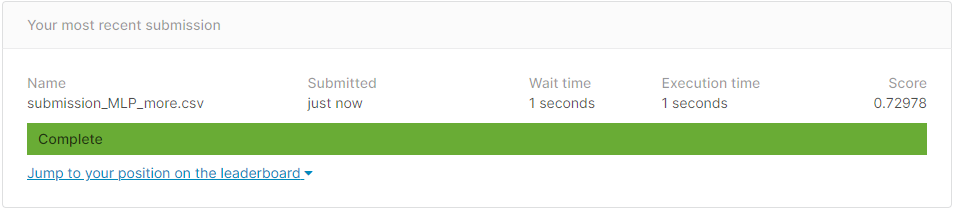